In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
from sep_ae_conv import concatmodel
from allmodel import autoencoder
from data_in import data_in, normali
#from autoencoder import autoencoder
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, y_train = data_in()

In [3]:
#Nomalization
y_train = (y_train-50)/150
X_train = normali(X_train)
print('Shape of X_train is: ' + str(X_train.shape))
print('Shape of y_train is: ' + str(y_train.shape))

Shape of X_train is: (3203, 1000, 5)
Shape of y_train is: (3203, 1)


In [4]:
X_train_PPG = X_train[:, :, :2]
X_train_acc = X_train[:, :, 2:]

Heart rate is: [79.5990566]


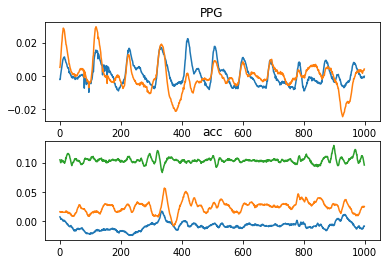

In [5]:
num_in = 10
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [6]:
#Add Gaussian Noise
sigma = 0.0025
mu = 0
noise = np.random.randn(X_train_PPG.shape[0], X_train_PPG.shape[1], X_train_PPG.shape[2])*sigma + mu
#noise[:, :, 2:5] = 0
X_train_PPG_noise = X_train_PPG + noise
X_train_PPG_noise = X_train_PPG_noise / (X_train_PPG_noise.max() - X_train_PPG_noise.min())

Heart rate is: [79.5990566]


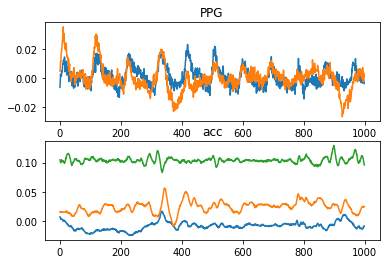

In [7]:
num_in = 10
print('Heart rate is: ' + str(y_train[num_in]*150+50))
plt.subplot(211)
plt.plot(X_train_PPG_noise[num_in, :, :])
plt.title('PPG')
plt.subplot(212)
plt.plot(X_train_acc[num_in, :, :])
plt.title('acc')
plt.show()

In [8]:
aemodel = autoencoder((1000, 2), 2, 16, padding_name='same', dropout_rate=0.1, weight_decay=1e-3)

In [9]:
aemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 2)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 2)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 16)          528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
activation_2 (Activation)    (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 64)           16448     
__________

In [10]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
aemodel.compile(loss= "mae", 
              optimizer=optm, 
              metrics=["mse"])

In [11]:
filepath="weight_troika_autoencoder_concat.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = aemodel.fit(X_train_PPG_noise, X_train_PPG, 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 2562 samples, validate on 641 samples
Epoch 1/50
2562/2562 [==============================] - 37s 14ms/step - loss: 0.3778 - mean_squared_error: 0.0014 - val_loss: 0.3645 - val_mean_squared_error: 7.5749e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00076, saving model to weight_troika_autoencoder_concat.hdf5
Epoch 2/50
2562/2562 [==============================] - 35s 14ms/step - loss: 0.3597 - mean_squared_error: 8.5720e-04 - val_loss: 0.3460 - val_mean_squared_error: 5.4112e-04

Epoch 00002: val_mean_squared_error improved from 0.00076 to 0.00054, saving model to weight_troika_autoencoder_concat.hdf5
Epoch 3/50
2562/2562 [==============================] - 36s 14ms/step - loss: 0.3388 - mean_squared_error: 5.8074e-04 - val_loss: 0.3262 - val_mean_squared_error: 4.7029e-04

Epoch 00003: val_mean_squared_error improved from 0.00054 to 0.00047, saving model to weight_troika_autoencoder_concat.hdf5
Epoch 4/50
2562/2562 [==============================] - 36s 14ms

2562/2562 [==============================] - 37s 15ms/step - loss: 0.0209 - mean_squared_error: 3.0404e-04 - val_loss: 0.0214 - val_mean_squared_error: 3.7601e-04

Epoch 00032: val_mean_squared_error did not improve from 0.00033
Epoch 33/50
2562/2562 [==============================] - 36s 14ms/step - loss: 0.0199 - mean_squared_error: 3.0644e-04 - val_loss: 0.0200 - val_mean_squared_error: 3.5849e-04

Epoch 00033: val_mean_squared_error did not improve from 0.00033
Epoch 34/50
2562/2562 [==============================] - 36s 14ms/step - loss: 0.0186 - mean_squared_error: 2.9707e-04 - val_loss: 0.0191 - val_mean_squared_error: 3.4408e-04

Epoch 00034: val_mean_squared_error did not improve from 0.00033
Epoch 35/50
2562/2562 [==============================] - 37s 14ms/step - loss: 0.0178 - mean_squared_error: 2.9558e-04 - val_loss: 0.0185 - val_mean_squared_error: 3.2686e-04

Epoch 00035: val_mean_squared_error improved from 0.00033 to 0.00033, saving model to weight_troika_autoencoder_c

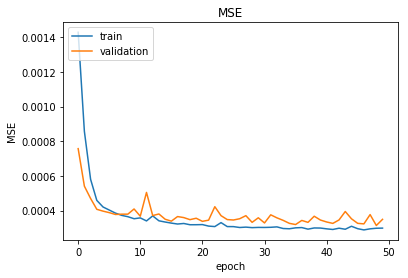

In [17]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

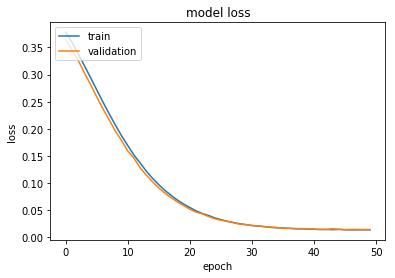

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
filepath="weight_troika_autoencoder_concat.hdf5"
aemodel.load_weights(filepath)

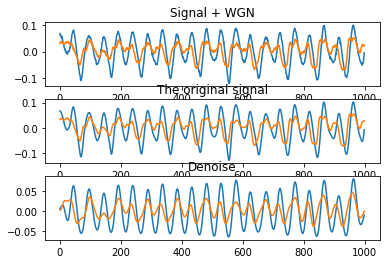

In [20]:
#Predict test set
predict_num = 1000
X_predict = X_train_PPG_noise[predict_num]
predict_res = aemodel.predict(np.expand_dims(X_predict, axis=0))

plt.subplot(3, 1, 1)
plt.plot(range(1000), X_train_PPG_noise[predict_num])
plt.title('Signal + WGN')
plt.subplot(3, 1, 2)
plt.plot(range(1000), X_train_PPG[predict_num])
plt.title('The original signal')
plt.subplot(3, 1, 3)
plt.plot(range(1000), predict_res[0])
plt.title('Denoise')
plt.show()

In [21]:
final_model = concatmodel((1000, 3), (1000,2), 8, aemodel, 12, dropout_rate=0.1, weight_decay=1e-6)

/Users/xufanxiong/Desktop/Troika_1/sep_ae_conv.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`
  model1 = Model(input=inputs_1, output=ori_layer)
/Users/xufanxiong/Desktop/Troika_1/sep_ae_conv.py:216: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`
  model2 = Model(input=inputs_2, output=newlayer)
/Users/xufanxiong/Desktop/Troika_1/sep_ae_conv.py:322: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("dr...)`
  finalmodel = Model(input=[inputs_1, inputs_2], output=final_layer)


In [22]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 2)      0                                            
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1000, 2)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 16)     528         activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1000, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [23]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
final_model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [25]:
filepath="weight_troika_sep_ae_model_concat.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = final_model.fit([X_train[:, :, 2:], X_train[:, :, :2]], y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=callbacks_list,
                    shuffle=True,
                    verbose=1)

Train on 2562 samples, validate on 641 samples
Epoch 1/100
2562/2562 [==============================] - 222s 87ms/step - loss: 0.0677 - mean_squared_error: 0.0565 - val_loss: 0.0333 - val_mean_squared_error: 0.0221

Epoch 00001: val_mean_squared_error improved from inf to 0.02206, saving model to weight_troika_sep_ae_model_concat.hdf5
Epoch 2/100
2562/2562 [==============================] - 236s 92ms/step - loss: 0.0659 - mean_squared_error: 0.0546 - val_loss: 0.0314 - val_mean_squared_error: 0.0201

Epoch 00002: val_mean_squared_error improved from 0.02206 to 0.02015, saving model to weight_troika_sep_ae_model_concat.hdf5
Epoch 3/100
2562/2562 [==============================] - 220s 86ms/step - loss: 0.0731 - mean_squared_error: 0.0618 - val_loss: 0.0327 - val_mean_squared_error: 0.0215

Epoch 00003: val_mean_squared_error did not improve from 0.02015
Epoch 4/100
2048/2562 [======================>.......] - ETA: 42s - loss: 0.0656 - mean_squared_error: 0.0544

KeyboardInterrupt: 

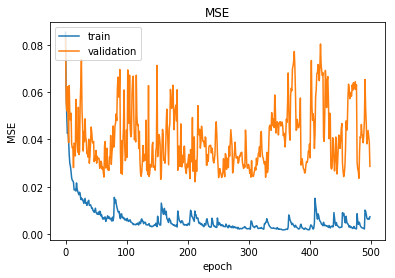

In [19]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

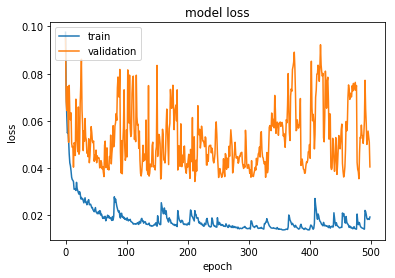

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
final_model.load_weights('weight_troika_sep_ae_model_concat.hdf5')

In [18]:
#Evaluate
#eva = finalmodel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
#print('loss = ' + str(eva[0]))
#print('Test MSE = ' + str(eva[1]))

In [31]:
#Import Test
X_test = sio.loadmat('Training_data/DATA_12_TYPE02.mat')
y_test = sio.loadmat('Training_data/DATA_12_TYPE02_BPMtrace.mat')
X_test = X_test['sig'].T
y_test = y_test['BPM0']
X_test = X_test[:, 1:]
print('The shape of X_test is: ' + str(X_test.shape))
print('The shape of y_test is: ' + str(y_test.shape))

The shape of X_test is: (37316, 5)
The shape of y_test is: (146, 1)


In [32]:
#Split data
tem = X_test
X_test = np.zeros((y_test.shape[0], 125*8, 5))
k = 0

for i in range(y_test.shape[0]):
    X_test[i, :, :] = tem[k:(k+125*8), :]
    k += 2*125
    
tem = 0
print('The shape of X_test is: ' + str(X_test.shape))

The shape of X_test is: (146, 1000, 5)


In [33]:
X_test = normali(X_test)
y_test = (y_test - 50)/150

In [34]:
predict = final_model.predict([X_test[:, :, 2:], X_test[:, :, :2]])

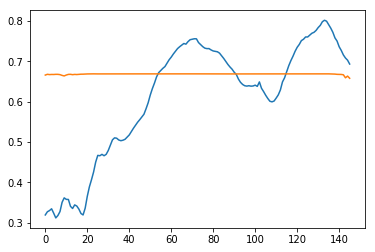

In [35]:
plt.plot(y_test)
plt.plot(predict)